In [1]:
import os
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import PIL
from tqdm.auto import tqdm
from ultralytics import YOLO
import copy
from diffusers import StableDiffusionInpaintPipeline
import torch
from torchvision import transforms
from skimage import feature
import torchvision.transforms as T
import io
import cv2

In [2]:
BASE_PATH = ''

In [3]:
with open(f'{BASE_PATH}captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

In [4]:
with open(f'{BASE_PATH}captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_PATH}train2017/{x}'
)
captions = captions.sort_values(by=["image"])
captions = captions.drop_duplicates(subset=['image'], keep='first')
captions = captions[:20000]
captions = captions.reset_index(drop=True)
captions

,image,caption
0,train2017/000000000009.jpg,Closeup of bins of food that include broccoli ...
1,train2017/000000000025.jpg,A giraffe standing up nearby a tree
2,train2017/000000000030.jpg,White vase with different colored flowers sitt...
3,train2017/000000000034.jpg,Zebra reaching its head down to ground where g...
4,train2017/000000000036.jpg,A woman with an umbrella near the sea
...,...,...
19995,train2017/000000098190.jpg,A little boy standing at a base getting ready ...
19996,train2017/000000098193.jpg,Man and woman holding their cell phones up to ...
19997,train2017/000000098194.jpg,Two dogs standing in front of debris in the sn...
19998,train2017/000000098197.jpg,A large black bear walking across a lush green...


Dog snoozing by a bike on the edge of a cobblestone street



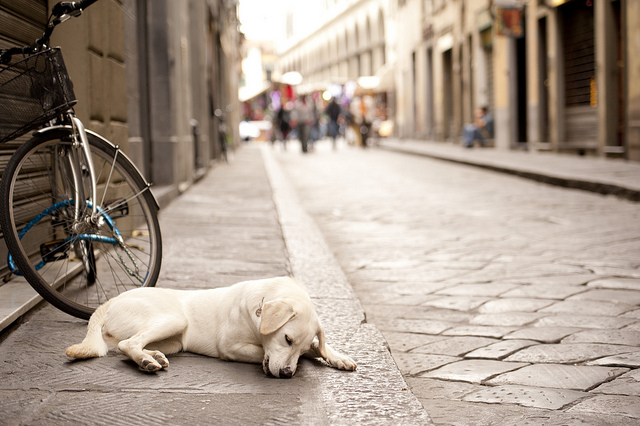

In [5]:
random_row = captions.iloc[12]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

In [6]:
device = torch.device("cuda", 0)
    
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float32
).to(device)

safety_checker/model.safetensors not found
/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.



0: 640x640 8 persons, 1 airplane, 16.8ms
Speed: 1.5ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


tensor([[178.6173, 202.8353, 233.7251, 396.1031,   0.8512,   0.0000],
        [  1.0742,  13.4142, 510.4086, 358.2696,   0.8493,   4.0000],
        [359.3073, 208.1721, 394.9332, 372.4440,   0.8016,   0.0000],
        [118.5377, 223.8500, 156.5495, 396.4213,   0.7753,   0.0000],
        [147.2954, 224.5011, 185.8946, 371.5209,   0.7118,   0.0000],
        [282.3181, 225.3467, 320.6076, 358.5012,   0.7025,   0.0000],
        [254.2813, 222.3978, 286.3518, 363.5103,   0.6739,   0.0000],
        [363.1609, 138.0279, 397.7356, 234.4698,   0.6632,   0.0000],
        [227.2581, 125.5432, 267.4404, 193.5990,   0.5441,   0.0000]], device='cuda:0')


  0%|          | 0/50 [00:00<?, ?it/s]

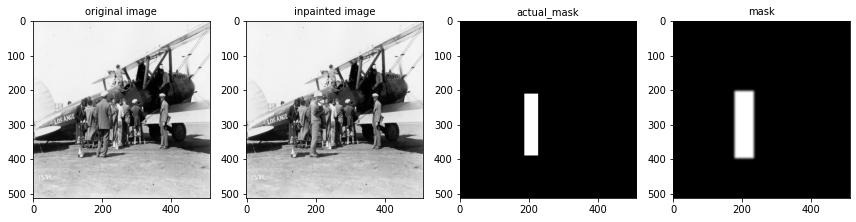

In [42]:
def generate_random_mask(image:Image.Image, minsize=8*512/64, maskradius=3):
    w, h = image.size
    orig_image = copy.deepcopy(image)
    model = YOLO("yolov8m.pt")
    results = model.predict(image, conf=0.5)[0]
    print(results.boxes.data)
    if len(results.boxes.data) > 0:
        x, y, x_end, y_end, confidence, class_id = results.boxes.data[0]
        
    else:
        x = round(random.random() * (w-minsize) + minsize/2)
        y = round(random.random() * (h-minsize) + minsize/2)
        cropw = round(random.random() * (w/2 - minsize)) + minsize
        croph = round(random.random() * (h/2 - minsize)) + minsize
        # print((x, y), (cropw, croph))
        x = max(0, round(x - cropw/2))
        y = max(0, round(y - croph/2))
        x_end = min(w, x + cropw)
        y_end = min(h, y + croph)
        
    mask = Image.new("L", image.size, 0)
    draw = PIL.ImageDraw.Draw(mask)
    draw.rectangle((x, y, x_end, y_end), fill=255)
    blurred_mask = mask.filter(PIL.ImageFilter.GaussianBlur(radius=maskradius))
    actual_mask = blurred_mask.point( lambda p: 255 if p >= 255 else 0 )
    # print((w, h), (x, y), (x_end, y_end))
    black = Image.new("RGB", image.size, 0)
    image = Image.composite(black, orig_image, actual_mask)    
    return image, actual_mask, blurred_mask, orig_image

def fake_inpaint(img, comp_mask, device, vae):
    x = transforms.ToTensor()(img).to(device)[None]
    posterior = vae.encode(x).latent_dist
    z = posterior.mode()
    dec = vae.decode(z).sample[0]
    inpainted = transforms.ToPILImage()(dec.clamp_(0, 1))
    ret = Image.composite(inpainted, img, comp_mask)
    return ret
    
row = captions.iloc[101]
im = Image.open(row.image).resize((512,512),PIL.Image.Resampling.BILINEAR)
caption = row.caption
out = generate_random_mask(im)

image, actual_mask, blurred_mask, orig_image
masked_image, mask, comp_mask, original_image = out

        
inpainted = pipe(prompt=caption, image=masked_image, mask_image=mask).images[0]


# fakeinpainted = fake_inpaint(original_image, blurred_mask, device=device, vae=pipe.vae)

inpainted.save(os.path.join(outputdir, k+".realfake.webp"), lossless=True)

inpainted = Image.composite(inpainted, masked_image, comp_mask)
inpainted.save(os.path.join(outputdir, k+".inpainted.webp"), lossless=True)

fakeinpainted.save(os.path.join(outputdir, k+".fakefake.webp"), lossless=True)
comp_mask.save(os.path.join(outputdir, k+".mask.webp"), lossless=True)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

ax[0].imshow(original_image)
ax[0].set_title('original image', fontsize=10)

ax[1].imshow(inpainted, cmap='gray')
ax[1].set_title(r'inpainted image', fontsize=10)

ax[2].imshow(mask, cmap='gray')
ax[2].set_title(r'actual_mask', fontsize=10)

ax[3].imshow(comp_mask, cmap='gray')
ax[3].set_title(r'mask', fontsize=10)



plt.tight_layout()
plt.show()

Using cache found in /home/hakim/.cache/torch/hub/facebookresearch_detr_main


0.60235595703125


  0%|          | 0/50 [00:00<?, ?it/s]

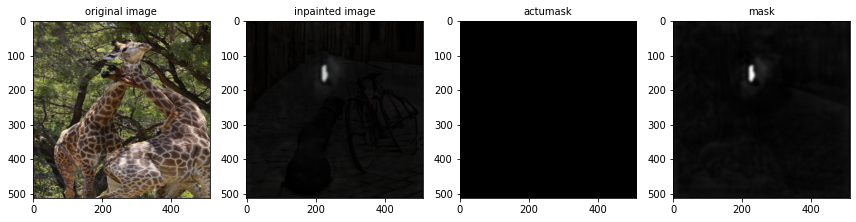

In [109]:
row = captions.iloc[12]
im = Image.open(row.image).resize((512,512),PIL.Image.Resampling.BILINEAR)
caption = row.caption

transform = T.Compose([
    T.ToTensor()
    ])

model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, return_postprocessor=True)
model.eval() 
image = im
image = transform(image).unsqueeze(0)
out = model(image) 
scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
keep = scores > 0.85
# arr_ = out["pred_masks"][keep][3].detach().numpy()
arr_ = None
for m in out["pred_masks"][keep]:
    
    col = Image.fromarray(m.detach().numpy(), 'L')
    grarray = np.asarray(gry)
    bw = (grarray > grarray.mean())*255
    print((np.sum(bw == 255) / 128**2))
    if (np.sum(bw == 255) / 128**2) < 0.7:
        arr_ = m.detach().numpy()
        break

stacked_img = np.stack((arr_,)*3, axis=-1) 
stacked_img = stacked_img.astype(np.uint8)
stacked_img = np.invert(stacked_img)

mask = PIL.Image.fromarray(arr_).convert("L").resize((512,512),PIL.Image.Resampling.BILINEAR)
# mask = mask.point( lambda p: 255 if p >= 1 else 0 )
blurred_mask = mask.filter(PIL.ImageFilter.GaussianBlur(radius=3))
actual_mask = blurred_mask.point( lambda p: 255 if p >= 1 else 0 )
black = Image.new("RGB", (512,512), 0)
image = Image.composite(black, orig_image, actual_mask)    

inpainted = pipe(prompt=caption, image=image, mask_image=actual_mask).images[0]
inpainted = Image.composite(inpainted, image, blurred_mask)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

ax[0].imshow(orig_image)
ax[0].set_title('original image', fontsize=10)

ax[1].imshow(inpainted, cmap='gray')
ax[1].set_title(r'inpainted image', fontsize=10)

ax[2].imshow(actual_mask, cmap='gray')
ax[2].set_title(r'actumask', fontsize=10)

ax[3].imshow(blurred_mask, cmap='gray')
ax[3].set_title(r'mask', fontsize=10)

plt.tight_layout()
plt.show()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
`label_ids_to_fuse` unset. No instance will be fused.


  0%|          | 0/50 [00:00<?, ?it/s]

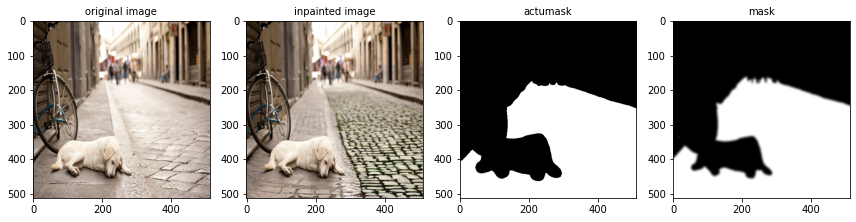

In [8]:
from transformers import AutoImageProcessor, MaskFormerForInstanceSegmentation
from PIL import Image


row = captions.iloc[12]
im = Image.open(row.image).resize((512,512),PIL.Image.Resampling.BILINEAR)
caption = row.caption

image_processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-coco")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-coco")

image = im
inputs = image_processor(images=image, return_tensors="pt")

outputs = model(**inputs)
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

result = image_processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

arr_ = None
for num in np.unique(result['segmentation'].numpy()):
    
    mask = (result['segmentation'].numpy() == num)
    visual_mask = (mask * 255).astype(np.uint8)

    if ((np.sum(visual_mask == 0) / (512*512)) < 0.7) and ((np.sum(visual_mask == 0) / (512*512)) > 0.2):
        arr_ = visual_mask
        break

mask = PIL.Image.fromarray(arr_).resize((512,512),PIL.Image.Resampling.BILINEAR)
# mask = mask.point( lambda p: 255 if p >= 1 else 0 )
blurred_mask = mask.filter(PIL.ImageFilter.GaussianBlur(radius=3))
actual_mask = blurred_mask.point( lambda p: 255 if p >= 255 else 0 )
black = Image.new("RGB", (512,512), 0)
image = Image.composite(black, im, actual_mask)    

inpainted = pipe(prompt=caption, image=image, mask_image=actual_mask).images[0]
inpainted = Image.composite(inpainted, image, blurred_mask)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

ax[0].imshow(im)
ax[0].set_title('original image', fontsize=10)

ax[1].imshow(inpainted, cmap='gray')
ax[1].set_title(r'inpainted image', fontsize=10)

ax[2].imshow(actual_mask, cmap='gray')
ax[2].set_title(r'actumask', fontsize=10)

ax[3].imshow(blurred_mask, cmap='gray')
ax[3].set_title(r'mask', fontsize=10)

plt.tight_layout()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

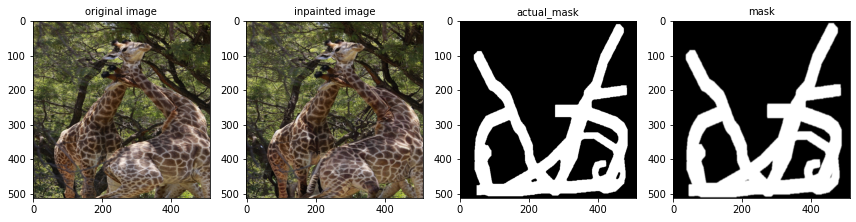

In [103]:
row = captions.iloc[10]
image = Image.open(row.image).resize((512,512),PIL.Image.Resampling.BILINEAR)
caption = row.caption
from scipy import ndimage
orig_image = copy.deepcopy(image)
mask = PIL.Image.open(f"qd_imd/test/000{40}_test.png").convert('L').resize((512,512),PIL.Image.Resampling.BILINEAR)
mask = PIL.ImageOps.invert(mask)
#mask = mask.filter(PIL.ImageFilter.MaxFilter(5))
mask = ndimage.maximum_filter(mask, size=15)
mask = PIL.Image.fromarray(mask).resize((512,512),PIL.Image.Resampling.BILINEAR)
blurred_mask = mask.filter(PIL.ImageFilter.GaussianBlur(radius=1))
actual_mask = blurred_mask.point( lambda p: 255 if p >= 255 else 0 )

black = Image.new("RGB", image.size, 0)
image = Image.composite(black, orig_image, actual_mask)    


        
inpainted = pipe(prompt=caption, image=image, mask_image=actual_mask).images[0]
inpainted = Image.composite(inpainted, image, blurred_mask)

# fakeinpainted = fake_inpaint(original_image, blurred_mask, device=device, vae=pipe.vae)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

ax[0].imshow(orig_image)
ax[0].set_title('original image', fontsize=10)

ax[1].imshow(inpainted, cmap='gray')
ax[1].set_title(r'inpainted image', fontsize=10)

ax[2].imshow(actual_mask, cmap='gray')
ax[2].set_title(r'actual_mask', fontsize=10)

ax[3].imshow(blurred_mask, cmap='gray')
ax[3].set_title(r'mask', fontsize=10)

plt.tight_layout()
plt.show()